# Telecom X — Parte 2 · Predicción de Churn (Colab-only)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/flacoca1970/Desafio_2_P2/blob/main/notebooks/TelecomX_P2_colab.ipynb)

Este **cuaderno único** ejecuta todo el flujo de **preprocesamiento, análisis, modelado, evaluación, calibración y selección de umbral de negocio** para predecir la cancelación (churn).
**Requisito**: usar el **CSV tratado** de la Parte 1 (`df_limpo.csv`).

> Tip: sube tu `df_limpo.csv` a `/content` o indica la ruta exacta abajo.


acompañamiento más fuerte a los clientes nuevos

In [1]:
# === Dependencias (solo en Colab) ===
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    !pip -q install imbalanced-learn >/dev/null


In [2]:
# === Imports y configuración ===
import os, warnings, io, json
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (roc_auc_score, average_precision_score, precision_recall_curve, roc_curve,
                             confusion_matrix, classification_report)
from sklearn.feature_selection import mutual_info_classif
from sklearn.inspection import permutation_importance

warnings.filterwarnings('ignore')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Opcional: oversampling (solo en train)
USE_BALANCING = False      # True para activar RandomOverSampler
BALANCING_METHOD = 'ros'   # 'ros' (RandomOverSampler) o 'smote'


In [3]:
# === Parámetros de entrada/salida ===
# Ruta del CSV tratado de la Parte 1
CSV_PATH = '/content/df_limpo.csv'     # cambia si lo tienes en otra ruta
# Parámetros de negocio para el umbral
VALUE_RETAIN = 100.0
COST_CONTACT = 5.0

# Donde guardar artefactos
os.makedirs('/content/reports', exist_ok=True)
os.makedirs('/content/data/interim', exist_ok=True)


## 1) Carga del dataset tratado (Parte 1)

In [4]:
# Cargar el CSV tratado (df_limpo)
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f'No se encontró el CSV tratado en: {CSV_PATH}. Sube df_limpo.csv o ajusta CSV_PATH.')

df = pd.read_csv(CSV_PATH)
print('Shape df:', df.shape)
display(df.head(3))
# Copia de seguridad en la estructura del proyecto (opcional)
df.to_csv('/content/data/interim/df_limpo.csv', index=False)


Shape df: (7267, 21)


,customerID,Churn,account.Contract,account.PaymentMethod,internet.InternetService,customer.tenure,account.MonthlyCharges,account.TotalCharges,customer.gender,customer.SeniorCitizen,...,customer.Dependents,phone.PhoneService,phone.MultipleLines,internet.OnlineSecurity,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.PaperlessBilling
0,0002-ORFBO,No,One year,Mailed check,DSL,9,65.6,593.30,Female,No,...,Yes,Yes,No,No,Yes,No,Yes,Yes,No,Yes
1,0003-MKNFE,No,Month-to-month,Mailed check,DSL,9,59.9,542.40,Male,No,...,No,Yes,Yes,No,No,No,No,No,Yes,No
2,0004-TLHLJ,Yes,Month-to-month,Electronic check,Fiber optic,4,73.9,280.85,Male,No,...,No,Yes,No,No,No,Yes,No,No,No,Yes


## 2) Preparación de datos (validación de target, split, pipelines)

In [6]:
# =========================
# 2) Preparación de datos (robusta a versión de sklearn)
# =========================
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# --- Validar target y limpiar filas no válidas para modelado
assert 'Churn' in df.columns, "El CSV tratado debe incluir la columna 'Churn'."

y_raw = df['Churn'].astype('string').str.strip().str.lower()
valid_mask = y_raw.isin(['yes','no'])
print(f"Filas totales: {len(y_raw)} | válidas (yes/no): {valid_mask.sum()} | inválidas/NaN: {(~valid_mask).sum()}")

dfm = df.loc[valid_mask].copy()
dfm['Churn_bin'] = dfm['Churn'].astype('string').str.strip().str.lower().map({'yes': 1, 'no': 0})

# --- Definir X y y
X = dfm.drop(columns=['Churn', 'Churn_bin', 'customerID'], errors='ignore')
y = dfm['Churn_bin'].to_numpy()

# --- Columnas numéricas y categóricas
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
print('Num cols:', len(num_cols), '| Cat cols:', len(cat_cols))

# --- Pipelines
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# OneHotEncoder compatible con sklearn >=1.2 (sparse_output) y <1.2 (sparse)
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # sklearn 1.2+
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)        # sklearn <1.2

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', ohe)
])

# Construir ColumnTransformer solo con los bloques que existan
transformers = []
if len(num_cols) > 0:
    transformers.append(('num', num_pipe, num_cols))
if len(cat_cols) > 0:
    transformers.append(('cat', cat_pipe, cat_cols))
if not transformers:
    raise ValueError("No hay columnas numéricas ni categóricas en X.")

pre = ColumnTransformer(transformers)

# --- Split estratificado (antes de cualquier balanceo)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print('Train:', X_train.shape, 'Test:', X_test.shape)

# --- Oversampling opcional (solo en train)
if USE_BALANCING:
    from imblearn.over_sampling import RandomOverSampler, SMOTE
    sampler = RandomOverSampler(random_state=RANDOM_STATE) if BALANCING_METHOD == 'ros' else SMOTE(random_state=RANDOM_STATE)
    Xt = pre.fit_transform(X_train)                # fit preprocesador y transformar train
    X_train_bal, y_train_bal = sampler.fit_resample(Xt, y_train)
    PRE_FITTED = pre                               # ya quedó "fitteado"
    X_train_array, y_train_array = X_train_bal, y_train_bal
else:
    PRE_FITTED = None
    X_train_array = None
    y_train_array = None


Filas totales: 7267 | válidas (yes/no): 7043 | inválidas/NaN: 224
Num cols: 3 | Cat cols: 16
Train: (5634, 19) Test: (1409, 19)


## 3) Análisis de correlación / selección de variables

Top 10 correlaciones numéricas con churn:
customer.tenure                     -0.3522
account.TotalCharges                -0.1995
account.MonthlyCharges              0.1934


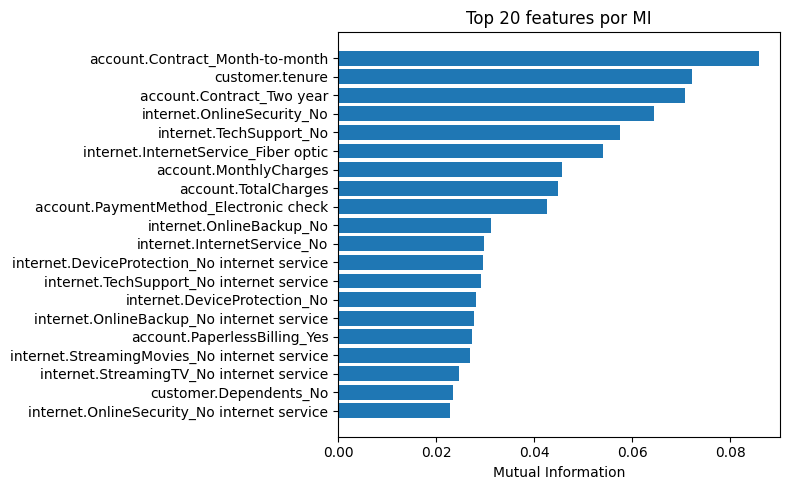

In [7]:
# 3.1 Punto-biserial aprox (Pearson con target binario) para numéricas
def safe_corr(a, b):
    try:
        return float(pd.Series(a).corr(pd.Series(b)))
    except Exception:
        return np.nan
corrs = []
for c in num_cols:
    corrs.append((c, safe_corr(dfm[c], dfm['Churn_bin'])))
corrs = sorted(corrs, key=lambda x: (abs(0 if x[1] is None else x[1])), reverse=True)
print('Top 10 correlaciones numéricas con churn:')
for c,v in corrs[:10]:
    print(f"{c:35s} {v:.4f}" if v==v else f"{c:35s} NaN")

# 3.2 Información Mutua (mixta: num + cat)
X_for_mi = pre.fit_transform(X)
mi = mutual_info_classif(X_for_mi, y, discrete_features=False, random_state=RANDOM_STATE)

def get_feature_names(pre, num_cols, cat_cols):
    out = []
    if 'num' in pre.named_transformers_ and pre.named_transformers_['num'] is not None:
        out.extend(num_cols)
    if 'cat' in pre.named_transformers_ and pre.named_transformers_['cat'] is not None:
        onehot = pre.named_transformers_['cat'].named_steps['onehot']
        out.extend(onehot.get_feature_names_out(cat_cols).tolist())
    return out
feat_names = get_feature_names(pre, num_cols, cat_cols)
mi_pairs = list(zip(feat_names, mi))
mi_pairs = sorted(mi_pairs, key=lambda x: x[1], reverse=True)

# Plot MI (top 20)
top = mi_pairs[:20]
plt.figure(figsize=(8,5))
plt.barh([n for n,_ in reversed(top)], [v for _,v in reversed(top)])
plt.xlabel('Mutual Information'); plt.title('Top 20 features por MI'); plt.tight_layout()
plt.show()


## 4) Modelos y GridSearch (métrica principal: PR-AUC)

In [8]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
models = {}
models['dummy'] = (DummyClassifier(strategy='stratified', random_state=RANDOM_STATE), {'model__strategy':['stratified']})
models['logreg'] = (LogisticRegression(max_iter=2000, class_weight='balanced'), {'model__C':[0.1,1,5,10]})
models['rf'] = (RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=RANDOM_STATE, class_weight='balanced'),
                {'model__max_depth':[None,8,14], 'model__min_samples_leaf':[1,3,6]})
models['gb'] = (GradientBoostingClassifier(random_state=RANDOM_STATE),
                {'model__n_estimators':[200,400], 'model__learning_rate':[0.05,0.1], 'model__max_depth':[2,3]})
models['hgb'] = (HistGradientBoostingClassifier(random_state=RANDOM_STATE),
                 {'model__max_depth':[None,10,14], 'model__learning_rate':[0.05,0.1]})
results = {}
best_est, best_name, best_score = None, None, -np.inf
for name, (est, grid) in models.items():
    pipe = Pipeline([('pre', pre), ('model', est)])
    gs = GridSearchCV(pipe, param_grid=grid, scoring='average_precision', cv=cv, n_jobs=-1)
    gs.fit(X_train, y_train)
    results[name] = gs.best_score_
    if gs.best_score_ > best_score:
        best_est, best_name, best_score = gs.best_estimator_, name, gs.best_score_
print('PR-AUC (CV) por modelo:')
for k,v in results.items():
    print(f"{k:8s} -> {v:.4f}")
print(f"Mejor: {best_name} (PR-AUC CV={best_score:.4f})")


PR-AUC (CV) por modelo:
dummy    -> 0.2686
logreg   -> 0.6507
rf       -> 0.6562
gb       -> 0.6612
hgb      -> 0.6450
Mejor: gb (PR-AUC CV=0.6612)


## 5) Calibración y evaluación en Test

ROC-AUC (test): 0.8481 | PR-AUC (test): 0.6639 | Calibración: isotonic


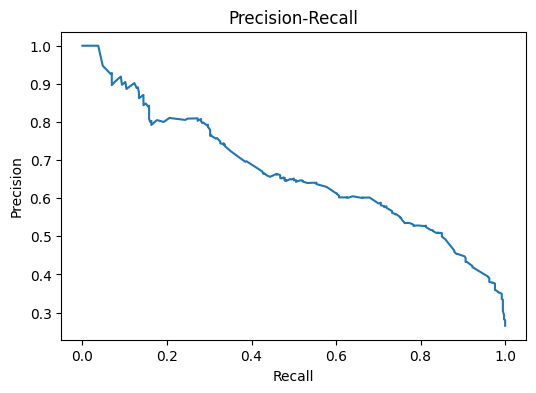

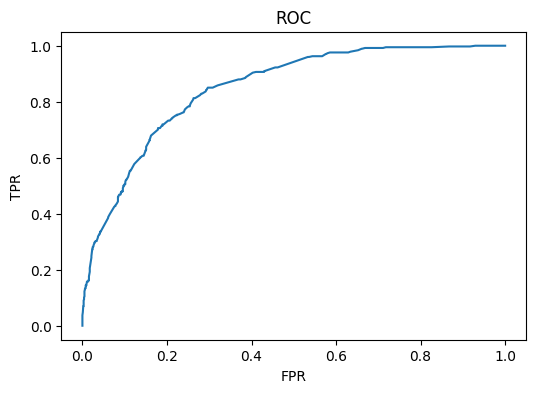

In [9]:
# Calibración (isotónica vs platt)
pre_fitted = best_est.named_steps['pre'].fit(X_train, y_train)
Xtr = pre_fitted.transform(X_train)
Xte = pre_fitted.transform(X_test)
base = best_est.named_steps['model']
cal_used = 'isotonic'
try:
    cal_iso = CalibratedClassifierCV(base, method='isotonic', cv=3).fit(Xtr, y_train)
    y_score = cal_iso.predict_proba(Xte)[:,1]
    cal_used = 'isotonic'
except Exception:
    try:
        cal_platt = CalibratedClassifierCV(base, method='sigmoid', cv=3).fit(Xtr, y_train)
        y_score = cal_platt.predict_proba(Xte)[:,1]
        cal_used = 'platt'
    except Exception:
        if hasattr(base, 'predict_proba'):
            y_score = base.fit(Xtr, y_train).predict_proba(Xte)[:,1]
            cal_used = 'none_proba'
        else:
            y_score = base.fit(Xtr, y_train).decision_function(Xte)
            y_min, y_max = y_score.min(), y_score.max()
            y_score = (y_score - y_min) / (y_max - y_min + 1e-9)
            cal_used = 'none_decision_scaled'
roc = roc_auc_score(y_test, y_score)
pr  = average_precision_score(y_test, y_score)
print(f'ROC-AUC (test): {roc:.4f} | PR-AUC (test): {pr:.4f} | Calibración: {cal_used}')
prec, rec, _ = precision_recall_curve(y_test, y_score)
fpr, tpr, _ = roc_curve(y_test, y_score)
plt.figure(figsize=(6,4)); plt.plot(rec, prec); plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall'); plt.show()
plt.figure(figsize=(6,4)); plt.plot(fpr, tpr); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC'); plt.show()


## 6) Umbral de negocio y matriz de confusión

Umbral óptimo: 0.03 | Ganancia estimada: 31635.0


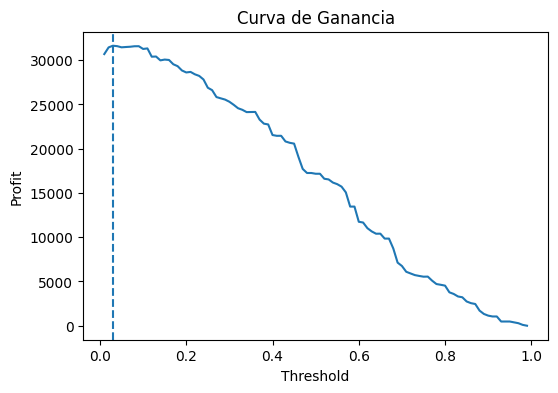

Matriz de confusión (umbral negocio):
 [[313 722]
 [  3 371]]
              precision    recall  f1-score   support

           0      0.991     0.302     0.463      1035
           1      0.339     0.992     0.506       374

    accuracy                          0.485      1409
   macro avg      0.665     0.647     0.485      1409
weighted avg      0.818     0.485     0.475      1409



In [10]:
def business_profit(y_true, y_score, thr, value=VALUE_RETAIN, cost=COST_CONTACT):
    y_pred = (y_score >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp*value - (tp+fp)*cost
thr_grid = np.linspace(0.01, 0.99, 99)
profits = [business_profit(y_test, y_score, t) for t in thr_grid]
best_thr = float(thr_grid[int(np.argmax(profits))])
best_profit = float(np.max(profits))
print('Umbral óptimo:', round(best_thr,3), '| Ganancia estimada:', round(best_profit,2))
plt.figure(figsize=(6,4)); plt.plot(thr_grid, profits); plt.axvline(best_thr, linestyle='--'); plt.xlabel('Threshold'); plt.ylabel('Profit'); plt.title('Curva de Ganancia'); plt.show()
y_pred = (y_score >= best_thr).astype(int)
cm = confusion_matrix(y_test, y_pred)
print('Matriz de confusión (umbral negocio):\n', cm)
print(classification_report(y_test, y_pred, digits=3))


## 7) Interpretabilidad (coeficientes / importancias / permutación)

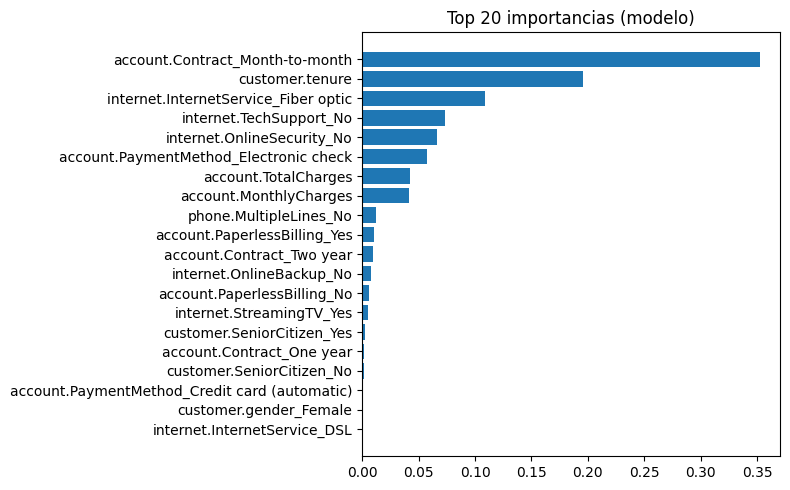

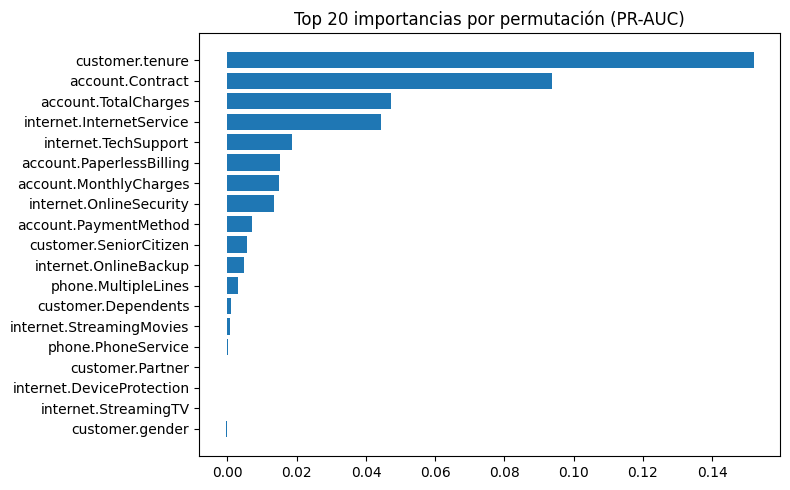

In [11]:
def get_feature_names(pre, num_cols, cat_cols):
    out = []
    if 'num' in pre.named_transformers_ and pre.named_transformers_['num'] is not None:
        out.extend(num_cols)
    if 'cat' in pre.named_transformers_ and pre.named_transformers_['cat'] is not None:
        onehot = pre.named_transformers_['cat'].named_steps['onehot']
        out.extend(onehot.get_feature_names_out(cat_cols).tolist())
    return out
feat_names = get_feature_names(pre_fitted, num_cols, cat_cols)
# 7.1 Coeficientes (si el modelo es lineal)
try:
    fitted = best_est.set_params().fit(X_train, y_train)
    clf = fitted.named_steps['model']
    if hasattr(clf, 'coef_'):
        coefs = clf.coef_.ravel() if getattr(clf, 'coef_', None) is not None else None
        if coefs is not None:
            names = get_feature_names(fitted.named_steps['pre'], num_cols, cat_cols)
            pairs = sorted(zip(names, coefs), key=lambda x: abs(x[1]), reverse=True)[:20]
            nn, vv = zip(*pairs)
            plt.figure(figsize=(8,5)); plt.barh(list(reversed(nn)), list(reversed(vv))); plt.title('Top 20 coeficientes (abs)'); plt.tight_layout(); plt.show()
except Exception as e:
    print('Coeficientes no disponibles:', e)
# 7.2 Feature importances (árboles)
try:
    if hasattr(base, 'feature_importances_'):
        imps = base.fit(pre_fitted.transform(X_train), y_train).feature_importances_
        pairs = sorted(zip(feat_names, imps), key=lambda x: x[1], reverse=True)[:20]
        nn, vv = zip(*pairs)
        plt.figure(figsize=(8,5)); plt.barh(list(reversed(nn)), list(reversed(vv))); plt.title('Top 20 importancias (modelo)'); plt.tight_layout(); plt.show()
except Exception as e:
    print('Importancias no disponibles:', e)
# 7.3 Permutation importance
try:
    perm = permutation_importance(best_est.set_params().fit(X_train, y_train), X_test, y_test, scoring='average_precision', n_repeats=5, random_state=RANDOM_STATE, n_jobs=-1)
    nn, vv = zip(*sorted(zip(X.columns, perm.importances_mean), key=lambda x: x[1], reverse=True)[:20])
    plt.figure(figsize=(8,5)); plt.barh(list(reversed(nn)), list(reversed(vv))); plt.title('Top 20 importancias por permutación (PR-AUC)'); plt.tight_layout(); plt.show()
except Exception as e:
    print('Permutation importance no disponible:', e)


## 8) Artefactos: metrics.json, informe P2 y export Top N

In [12]:
# Guardar métricas clave
metrics = {
    'best_model': str(best_name),
    'cv_best_pr_auc': float(best_score),
    'test_roc_auc': float(roc_auc_score(y_test, y_score)),
    'test_pr_auc': float(average_precision_score(y_test, y_score)),
    'business_best_threshold': float(best_thr),
    'business_best_profit': float(best_profit),
    'value_retain': float(VALUE_RETAIN),
    'cost_contact': float(COST_CONTACT),
    'calibration': cal_used
}
with open('/content/reports/metrics_p2.json','w') as f:
    json.dump(metrics, f, indent=2)
print('Guardado /content/reports/metrics_p2.json')

# Informe Markdown P2
lines = []
lines.append('# Informe de Resultados — Telecom X · Parte 2')
lines.append('')
lines.append('## 1. Datos y preparación')
lines.append(f'- Filas: **{df.shape[0]}** | Columnas: **{df.shape[1]}**')
lines.append(f'- Columnas numéricas: **{len(num_cols)}** | categóricas: **{len(cat_cols)}**')
lines.append('- Split: **train/test 80/20** estratificado; oversampling: **%s**' % ('Sí' if USE_BALANCING else 'No'))
lines.append('')
lines.append('## 2. Selección de variables (resumen)')
lines.append('- Top 10 numéricas por correlación (abs):')
for c,v in (corrs[:10] if isinstance(corrs, list) else []):
    lines.append(f'  - {c}: {v:.4f}' if v==v else f'  - {c}: NaN')
lines.append('- Top 20 features por Información Mutua (ver gráfico en el notebook).')
lines.append('')
lines.append('## 3. Modelado y evaluación')
lines.append(f'- **Mejor modelo (CV por PR-AUC)**: **{best_name}** con **{best_score:.4f}**')
lines.append(f'- En test: **ROC-AUC**={roc:.4f}, **PR-AUC**={pr:.4f}, **calibración**={cal_used}')
lines.append('')
lines.append('## 4. Umbral y negocio')
lines.append(f'- Threshold óptimo: **{best_thr:.3f}** → Ganancia estimada: **{best_profit:.2f}** (VALUE_RETAIN={VALUE_RETAIN}, COST_CONTACT={COST_CONTACT})')
tn, fp, fn, tp = confusion_matrix(y_test, (y_score>=best_thr).astype(int)).ravel()
lines.append('')
lines.append('**Matriz de confusión (umbral negocio):**')
lines.append('')
lines.append('|       | Pred No | Pred Yes |')
lines.append('|-------|---------|----------|')
lines.append(f'| Real No  | {tn} | {fp} |')
lines.append(f'| Real Yes | {fn} | {tp} |')
lines.append('')
lines.append('## 5. Conclusiones')
lines.append('- Factores con mayor influencia alineados con la Parte 1 (contrato mes a mes, e-check, fibra).')
lines.append('- El umbral maximiza **ganancia**, priorizando recall si `VALUE_RETAIN` es alto respecto a `COST_CONTACT`.')
lines.append('- Recomendación: campañas por segmento con anualización, migración a auto-pay y soporte fibra proactivo.')
with open('/content/reports/README_REPORT_P2.md','w', encoding='utf-8') as f:
    f.write('\n'.join(lines))
print('Guardado /content/reports/README_REPORT_P2.md')

# Export Top N para CRM
N = 500
salida = dfm.loc[X_test.index].copy()
salida['churn_score'] = y_score
salida['flag_churn_risk'] = (y_score >= best_thr).astype(int)
topN = salida.sort_values('churn_score', ascending=False).head(N)
top_path = '/content/reports/clientes_en_riesgo_topN_p2.csv'
topN.to_csv(top_path, index=False)
print('Exportado:', top_path)
try:
    display(topN.head(10))
except Exception:
    pass


Guardado /content/reports/metrics_p2.json
Guardado /content/reports/README_REPORT_P2.md
Exportado: /content/reports/clientes_en_riesgo_topN_p2.csv


,customerID,Churn,account.Contract,account.PaymentMethod,internet.InternetService,customer.tenure,account.MonthlyCharges,account.TotalCharges,customer.gender,customer.SeniorCitizen,...,internet.OnlineSecurity,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.PaperlessBilling,Churn_bin,churn_score,flag_churn_risk
5963,8149-RSOUN,Yes,Month-to-month,Electronic check,Fiber optic,1,93.85,93.85,Female,No,...,No,No,No,No,Yes,Yes,Yes,1,0.980117,1
3964,5419-JPRRN,Yes,Month-to-month,Electronic check,Fiber optic,1,101.45,101.45,Male,No,...,No,No,Yes,No,Yes,Yes,Yes,1,0.976456,1
65,0107-YHINA,Yes,Month-to-month,Electronic check,Fiber optic,1,99.75,99.75,Male,No,...,No,No,Yes,No,Yes,Yes,Yes,1,0.976456,1
3563,4910-GMJOT,Yes,Month-to-month,Electronic check,Fiber optic,1,94.60,94.60,Female,No,...,No,No,No,No,Yes,Yes,Yes,1,0.968686,1
4764,6521-YYTYI,Yes,Month-to-month,Electronic check,Fiber optic,1,93.30,93.30,Male,No,...,No,No,No,No,Yes,Yes,Yes,1,0.958146,1
3162,4415-IJZTP,Yes,Month-to-month,Electronic check,Fiber optic,1,74.50,74.50,Female,No,...,No,No,No,No,No,No,Yes,1,0.924203,1
1834,2609-IAICY,Yes,Month-to-month,Electronic check,Fiber optic,1,77.15,77.15,Female,No,...,No,No,No,No,No,No,Yes,1,0.924203,1
7030,9681-OXGVC,Yes,Month-to-month,Electronic check,Fiber optic,5,100.50,514.00,Female,No,...,No,No,Yes,No,Yes,Yes,Yes,1,0.924203,1
4066,5567-WSELE,Yes,Month-to-month,Electronic check,Fiber optic,3,94.60,279.55,Male,Yes,...,No,No,No,No,Yes,Yes,Yes,1,0.924203,1
2122,2982-IHMFT,Yes,Month-to-month,Mailed check,Fiber optic,1,74.45,74.45,Female,Yes,...,No,No,No,No,No,No,Yes,1,0.924203,1
